<a href="https://colab.research.google.com/github/Galadriel-LORD/GaladrieL/blob/master/cnn_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rede Neural Convolucional para classificação de imagens de gatos e cachorros

O dataset tem 25000 imagens com label, onde foi utilizado 4000.
 80% para treino, 20% para validação.

 Foram utilizadas 128 imagens para teste.

 Tentou-se usar apenas 400 imagens como nos outros algoritmos, contudo, a rede aprendeu apenas uma classe. Para solucionar o problema, foram feitas as seguintes tentativas:

retirar a image augumentation do image generator;

diminuir o tamanho das batches;

mudar os dropout das layers;

Tudo isso apenas piorou a situação.

Depois, resolveu-se diminuir a robustes da rede, diminuindo o número de parâmetros por camada para evitar o overfitting, pois haviam poucos dados. Funcionou, as validation loss foram drásticamentes reduzidas. Contudo, percebeu-se que devido ao baixo numero de dados, a acurácia se manteve muito baixa, e o progresso de aprendizagem foi completamente aleatório.

Por fim, aumentou-se a quantidade de imagens, e funcionou como esperado. 2k para dogs, 2k para gatos. 3200 para treino, 800 para teste.

Para métrica, utilizou-se os dados de validação, pois continham labels, para se obter a matriz confusão.

Fez-se a predição com imagens do set de test. Com uma amostra de 18 imagens, a rede acertou todas as 18.

Tudo isto pode ser visualizado no código abaixo


# Import Library

In [2]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
!kaggle competitions download -c dogs-vs-cats



  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 33.3MB/s]
 98% 531M/543M [00:03<00:00, 172MB/s]
100% 543M/543M [00:03<00:00, 178MB/s]
 94% 255M/271M [00:01<00:00, 169MB/s]
100% 271M/271M [00:01<00:00, 149MB/s]


In [4]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import glob
from tensorflow import keras
from google.colab import files




In [5]:

!ls

kaggle.json  sample_data  sampleSubmission.csv	test1.zip  train.zip


# Define Constants

In [6]:

IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Prepare Traning Data

In [ ]:
!unzip 'test1.zip'

In [ ]:
!unzip 'train.zip'

In [126]:
# pegando 400 imagens das 25k
filenames = os.listdir("train")
categories = []
data = []
names = []
d = 0
c = 1

for (i, filename) in enumerate(filenames):

  img = load_img("train/"+filename)


  category = filename.split('.')[0]
  if category == 'dog':
    if d == 2000: continue  # altera pra 4k
    d += 1
    categories.append(1)
    names.append(filename)
    data.append(img)

  else:
      if c == 2000: continue
      c += 1
      categories.append(0)
      names.append(filename)
      data.append(img)
print('c: {}'.format(c), '\n', 'd: {}'.format(d))

df = pd.DataFrame({
    'filename': names,
    'category': categories
})

c: 2000 
 d: 2000


In [124]:
type(data[0]) # imagens carregadas para uma lista. será o total de dados

PIL.JpegImagePlugin.JpegImageFile

In [127]:
len(data)

3999

In [ ]:
df.head()

filename  category
0   dog.4602.jpg         1
1   dog.4723.jpg         1
2   dog.1325.jpg         1
3  cat.11998.jpg         0
4  cat.11927.jpg         0

In [10]:
df.iloc[195:205]

filename  category
195   dog.9100.jpg         1
196   cat.5888.jpg         0
197   cat.2488.jpg         0
198   cat.7695.jpg         0
199   dog.7418.jpg         1
200   cat.6472.jpg         0
201   cat.4965.jpg         0
202   cat.7427.jpg         0
203  cat.10053.jpg         0
204   dog.4296.jpg         1

In [11]:
df.tail()

filename  category
394  dog.8371.jpg         1
395   dog.255.jpg         1
396  dog.5280.jpg         1
397  cat.9371.jpg         0
398  dog.8171.jpg         1

### See Total In count

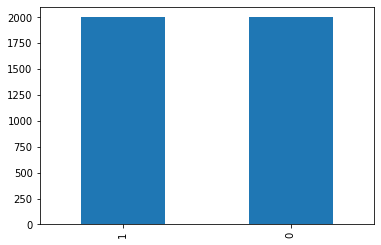

In [128]:
# 200 de cada
df['category'].value_counts().plot.bar()

# See sample image

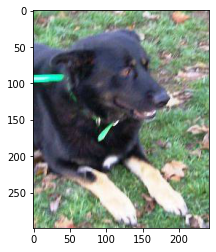

In [13]:
sample = random.choice(df.filename)
image = load_img("train/"+sample)
plt.imshow(image)

# Build Model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Input Layer**: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
* **Conv Layer**: This layer will extract features from image.
* **Pooling Layer**: This layerreduce the spatial volume of input image after convolution.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: It is the predicted values layer. 

In [129]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2))) # diminuindo as dimensoes das imagens pela metade
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) # tornando um sóh array para entrar na dense layer
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# rmsprop optmizer adapta a taxa de learning, para cada weight utilizando minibatches.
# olha o sinal da taxa , dos ultimos 2 iterações. Se for igual, dá uma aceleradinha.
# o gradiente é dividido pela raiz quadrada media (rms) de todos gradientes, para cada peso
# mt utilizado para casos que nao convergem. ADAgrad é similar, mas o grad eh acumulado a cada step
# e vai diminuindo. O que é óyimo, para casos de convergencia.

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_22 (Bat  (None, 126, 126, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 63, 63, 32)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_23 (Bat  (None, 61, 61, 64)      

In [93]:
# # modelo para menos imagens

# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

# model = Sequential()

# model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2))) # diminuindo as dimensoes das imagens pela metade
# model.add(Dropout(0.25))

# model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Flatten()) # tornando um sóh array para entrar na dense layer
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid')) # 2 because we have cat and dog classes, sigmoid: eh uma ou eh outra

# model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy']) # bynary cross entropy
# # rmsprop optmizer adapta a taxa de learning, para cada weight utilizando minibatches.
# # olha o sinal da taxa , dos ultimos 2 iterações. Se for igual, dá uma aceleradinha.
# # o gradiente é dividido pela raiz quadrada media (rms) de todos gradientes, para cada peso
# # mt utilizado para casos que nao convergem. ADAgrad é similar, mas o grad eh acumulado a cada step
# # e vai diminuindo. O que é óyimo, para casos de convergencia.


# Callbacks

In [14]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Early Stop**

To prevent over fitting we will stop the learning after 2 epochs and val_loss value not decreased

In [67]:
earlystop = EarlyStopping(patience=5) # teste com callback em 5 epochs

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [16]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [17]:
callbacks = [earlystop, learning_rate_reduction]

# Prepare data

Because we will use image genaretor `with class_mode="categorical"`. We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification. 

So we will convert 1 to dog and 0 to cat

In [130]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [94]:
# sigmoid data
df["category"] = df["category"].replace({'cat': 0, 'dog': 1}) 

In [131]:
df.tail()

filename category
3994   cat.5932.jpg      cat
3995   cat.7579.jpg      cat
3996  cat.11003.jpg      cat
3997   cat.7979.jpg      cat
3998   cat.4355.jpg      cat

In [20]:
# manipulando o df para que a primeira metade seja cat, e a segunda seja dog:
df = df.sort_values(by='category')

In [193]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [133]:
train_df.tail()

filename category
3194   cat.8297.jpg      cat
3195  dog.10036.jpg      dog
3196   cat.9883.jpg      cat
3197  dog.11374.jpg      dog
3198   cat.4258.jpg      cat

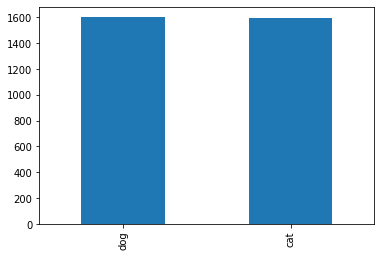

In [134]:
train_df['category'].value_counts().plot.bar()

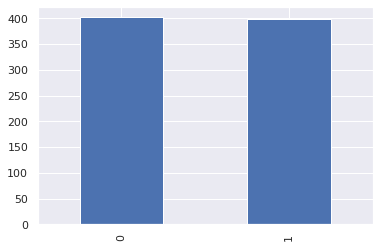

In [192]:
validate_df['category'].value_counts().plot.bar()

In [136]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [159]:
total_train

3199

# Traning Generator

In [138]:
#deixar apenas o rescale, para ser justo com os outros algoritmos.
# alterar a imagem toda vez que ela passa num epoch, bom pois temos poucas imagens nesse exemplo.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# aqui, train generator é responsável por pegar cada imagem na pasta train, as que tem o nome do filename em df_trian
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    'train/', 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 3199 validated image filenames belonging to 2 classes.


In [111]:
# # sigmoid generator

# #deixar apenas o rescale, para ser justo com os outros algoritmos.
# # alterar a imagem toda vez que ela passa num epoch, bom pois temos poucas imagens nesse exemplo.
# train_datagen = ImageDataGenerator(
#     rotation_range=15,
#     rescale=1./255,
#     shear_range=0.1,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     width_shift_range=0.1,
#     height_shift_range=0.1
# )

# # aqui, train generator é responsável por pegar cada imagem na pasta train, as que tem o nome do filename em df_trian
# train_generator = train_datagen.flow_from_dataframe(
#     train_df, 
#     'train/', 
#     x_col='filename',
#     y_col='category',
#     target_size=IMAGE_SIZE,
#     class_mode='binary',
#     batch_size=batch_size
)

Found 319 validated image filenames belonging to 2 classes.


### Validation Generator

In [139]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical', # trocar para categorical quando nao usar sigmoid ou deixar binary
    batch_size=batch_size
)

Found 800 validated image filenames belonging to 2 classes.


# See how our generator work

In [140]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


Seem to be nice 

# Fit Model

In [141]:
epochs=25
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/25
213/213 [==============================] - 166s 772ms/step - loss: 1.2188 - accuracy: 0.5606 - val_loss: 1.0885 - val_accuracy: 0.4981 - lr: 0.0010
Epoch 2/25
213/213 [==============================] - 163s 766ms/step - loss: 0.8123 - accuracy: 0.5942 - val_loss: 0.9313 - val_accuracy: 0.5447 - lr: 0.0010
Epoch 3/25
213/213 [==============================] - 163s 766ms/step - loss: 0.6851 - accuracy: 0.6329 - val_loss: 0.6586 - val_accuracy: 0.6566 - lr: 0.0010
Epoch 4/25
213/213 [==============================] - 162s 761ms/step - loss: 0.6447 - accuracy: 0.6523 - val_loss: 0.5873 - val_accuracy: 0.6893 - lr: 0.0010
Epoch 5/25
213/213 [==============================] - 163s 767ms/step - loss: 0.6072 - accuracy: 0.6828 - val_loss: 0.5751 - val_accuracy: 0.7107 - lr: 0.0010
Epoch 6/25
213/213 [==============================] - 163s 763ms/step - loss: 0.5881 - accuracy: 0.6944 - val_loss: 0.5923 - val_accuracy: 0.7119 - lr: 0.0010
Epoch 7/25
213/213 [==========================

# Save Model and load

In [ ]:
# model.save("my_model")
# files.download("my_model")

In [ ]:
# # Load the previously saved weights
# model.save_weights('weights')



In [ ]:
# model.load_weights('weights')


In [ ]:
# #loading the model with pre trained weights:
# # It can be used to reconstruct the model identically.
# reconstructed_model = keras.models.load_model("my_model")

# # Let's check:
# np.testing.assert_allclose(
#     model.predict(validation_generator), reconstructed_model.predict()
# )

# # The reconstructed model is already compiled and has retained the optimizer
# # state, so training can resume:
# reconstructed_model.fit(validation_generator, test_target)

# Virtualize Training

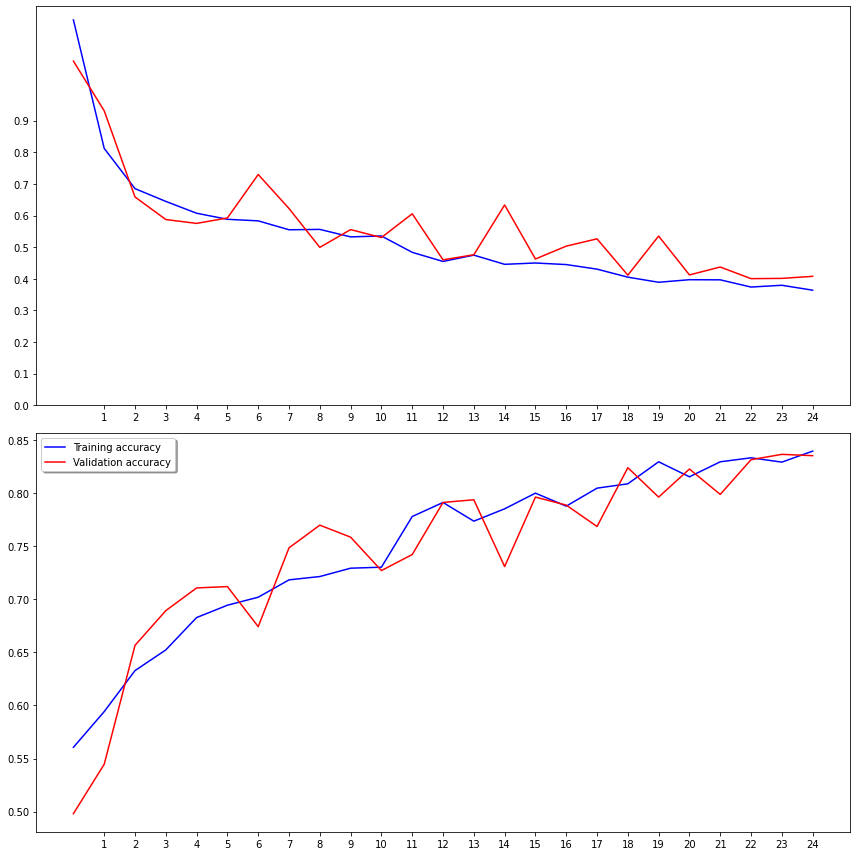

In [144]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))


ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Prepare Testing Data

In [145]:
test_filenames = os.listdir("test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
#teste com as ultimas 128 imagens
# test_df = test_df.iloc[(12500-128):]

#teste com as primeiras 128
test_df = test_df.iloc[:128]
nb_samples = test_df.shape[0]

In [146]:
test_df.shape

(128, 1)

In [77]:
test_df.tail()

filename
123  12315.jpg
124   9375.jpg
125   4004.jpg
126    425.jpg
127   1375.jpg

In [156]:
len(test_df)

128

# Create Testing Generator

In [147]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

# test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

Found 128 validated image filenames.


# Predict

In [160]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))



In [225]:
len(predict)

128

In [149]:
for i in predict:
  print(i)

[0.02139593 0.9786041 ]
[0.98884773 0.01115221]
[0.22982958 0.7701704 ]
[0.03122054 0.96877944]
[0.90677476 0.09322519]
[6.686378e-05 9.999331e-01]
[0.0370084 0.9629916]
[0.37159377 0.6284063 ]
[0.01830823 0.9816917 ]
[0.02165554 0.97834444]
[0.7612885  0.23871145]
[0.05360663 0.94639343]
[0.07738923 0.9226108 ]
[0.24762656 0.75237346]
[0.7393369  0.26066315]
[0.99574465 0.00425529]
[0.10665049 0.89334947]
[0.96597856 0.03402144]
[0.96145    0.03854994]
[0.00211841 0.9978816 ]
[0.01048892 0.9895111 ]
[0.07048815 0.9295118 ]
[0.01123372 0.98876625]
[0.97291756 0.02708246]
[0.9670445  0.03295551]
[0.9653148  0.03468519]
[0.12269448 0.87730557]
[0.16061732 0.83938265]
[9.9999857e-01 1.4466445e-06]
[0.04419371 0.95580626]
[0.92904097 0.07095907]
[0.91584307 0.08415689]
[0.9297103 0.0702897]
[0.00289928 0.99710065]
[0.00629257 0.9937075 ]
[0.22395879 0.7760412 ]
[0.97479886 0.02520121]
[0.9972894  0.00271055]
[0.8601567  0.13984326]
[0.87520164 0.12479836]
[0.05249999 0.9475    ]
[8.754511e

In [162]:
len (predict)

128

For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

In [210]:
test_df['category'] = np.argmax(predict, axis=-1)

In [211]:
test_df.tail()

filename  category
123  12315.jpg         1
124   9375.jpg         1
125   4004.jpg         0
126    425.jpg         1
127   1375.jpg         0

We will convert the predict category back into our generator classes by using `train_generator.class_indices`. It is the classes that image generator map while converting data into computer vision

In [212]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items()) # replace com 0 = cat, 1 = dog
test_df['category'] = test_df['category'].replace(label_map)

In [213]:
test_df.tail()

filename category
123  12315.jpg      dog
124   9375.jpg      dog
125   4004.jpg      cat
126    425.jpg      dog
127   1375.jpg      cat

From our prepare data part. We map data with `{1: 'dog', 0: 'cat'}`. Now we will map the result back to dog is 1 and cat is 0

In [166]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

### Virtaulize Result

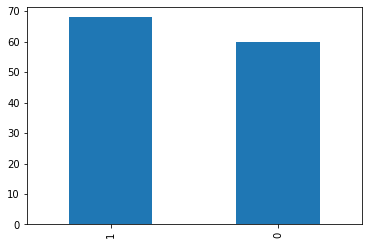

In [167]:
test_df['category'].value_counts().plot.bar()

### See predicted result with images

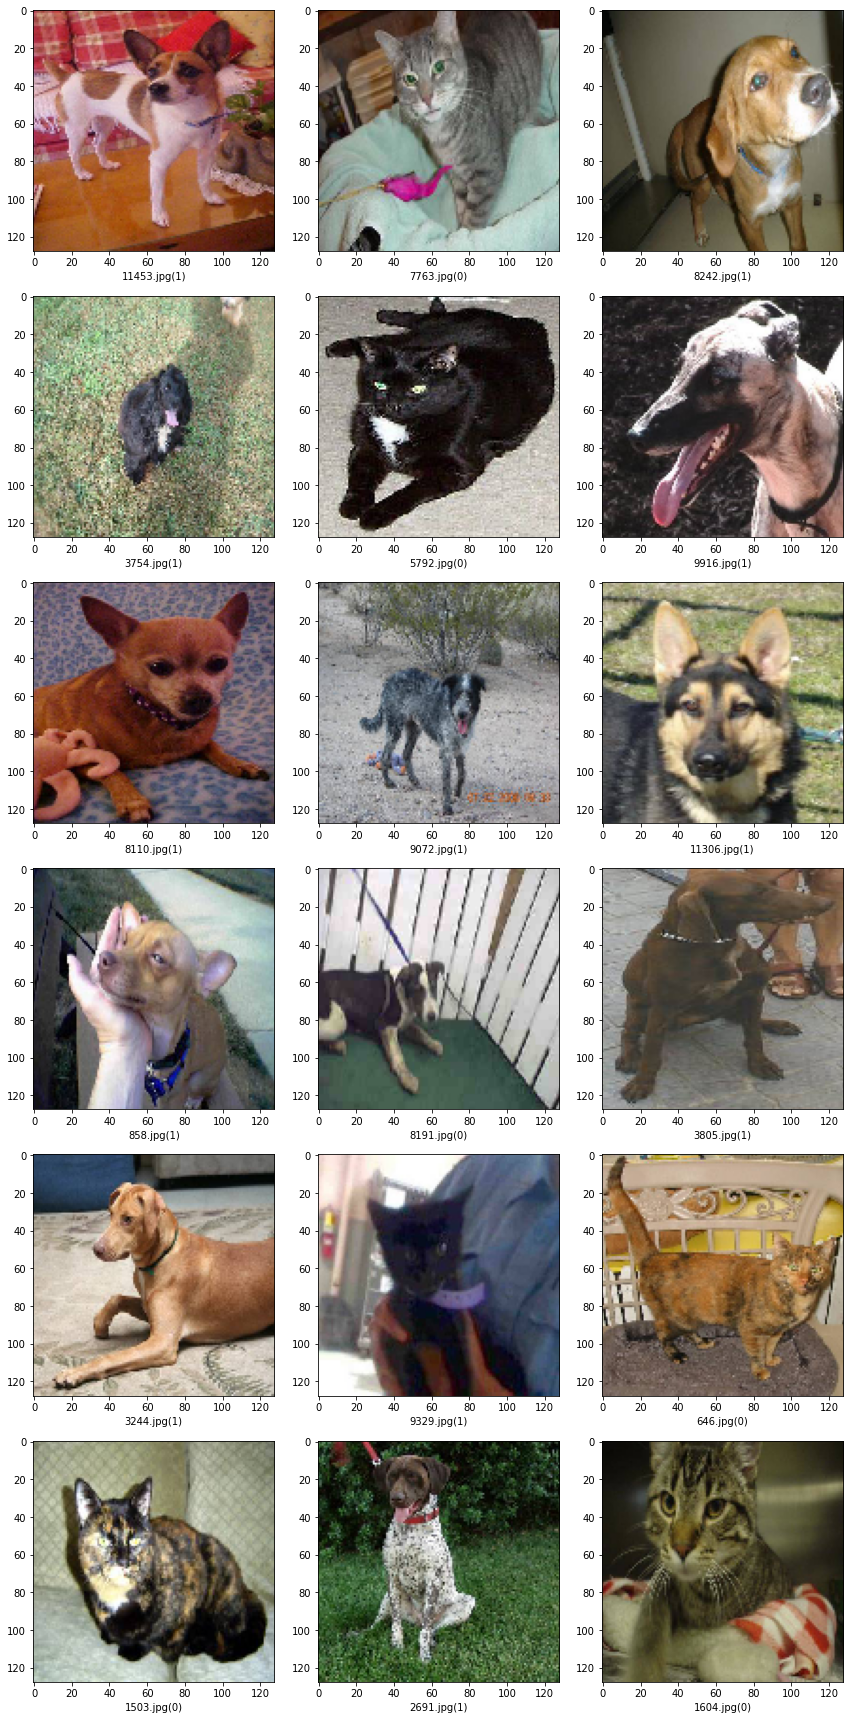

In [168]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

Fazendo a matriz confusão com as 800 imagens de validação:

In [222]:
validate_df['category'] = validate_df['category'].replace({ 1:'dog', 0:'cat' })

In [223]:
#usando para isso as imagens de validação, pois tem label


validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical', # trocar para categorical quando nao usar sigmoid ou deixar binary
    batch_size=batch_size
)

Found 800 validated image filenames belonging to 2 classes.


In [227]:
# validation predict
predictt = model.predict(validation_generator, steps=np.ceil(nb_samples/batch_size))  #fazendo a prediçao com os examples de validação


In [214]:
validate_df['predicted']= np.argmax(predictt, axis=-1) # adicionando uma coluna de dados previstos ao dataframe, para ser usado na matriz confusão

In [224]:
validate_df['category'] = validate_df['category'].replace({ 'dog': 1, 'cat': 0 }) # mudando as categorias para 0 e 1
validate_df.head()

filename  category  predicted
0   cat.7798.jpg         0          0
1   cat.1269.jpg         0          0
2   cat.8790.jpg         0          1
3  cat.10156.jpg         0          0
4   dog.3475.jpg         1          0

In [217]:
validate_df.where(validate_df['category'] == validate_df['predicted']).dropna() # vendo os dados que foram previstos, e comparando

filename  category  predicted
0     cat.7798.jpg       0.0        0.0
1     cat.1269.jpg       0.0        0.0
3    cat.10156.jpg       0.0        0.0
6      cat.321.jpg       0.0        0.0
7    cat.12311.jpg       0.0        0.0
..             ...       ...        ...
792  dog.10584.jpg       1.0        1.0
793   cat.7374.jpg       0.0        0.0
794   dog.1011.jpg       1.0        1.0
796   dog.5462.jpg       1.0        1.0
797   dog.4966.jpg       1.0        1.0

[409 rows x 3 columns]

A matriz confusão!

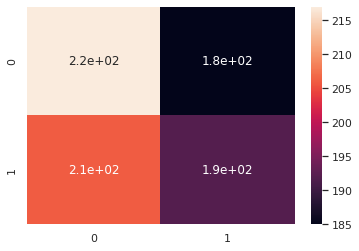

In [202]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set_theme()

conf = confusion_matrix(validate_df['category'], validate_df['predicted'])
sns.heatmap(conf, annot=True)                       
                        


Pela matriz confusão, vemos que a rede, que tem val_loss: 0.4077 - val_accuracy: 0.8352, acerta 190 em imagens de dogs (1), e 220 para gatos(0).

Ela erra ao ver 210 imagens de dogs, e 180 imagens de gatos

In [220]:
# usando as imagens de validação, que tem label, pra ver a predição:
sample_test = validate_df[18:36]

for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    pred = row['predicted']
    
    print(filename + ' ' + '(' + "{}".format(category) + ')' + ' ' + "{}".format(pred) )
    


cat.9506.jpg (0) 1
cat.209.jpg (0) 0
cat.4943.jpg (0) 0
dog.7401.jpg (1) 1
dog.5985.jpg (1) 1
dog.11777.jpg (1) 1
dog.5633.jpg (1) 0
dog.4675.jpg (1) 1
cat.4810.jpg (0) 0
dog.4098.jpg (1) 1
cat.12355.jpg (0) 0
dog.3674.jpg (1) 0
cat.7980.jpg (0) 1
cat.5463.jpg (0) 0
dog.11592.jpg (1) 1
dog.12261.jpg (1) 1
dog.833.jpg (1) 0
dog.7154.jpg (1) 1


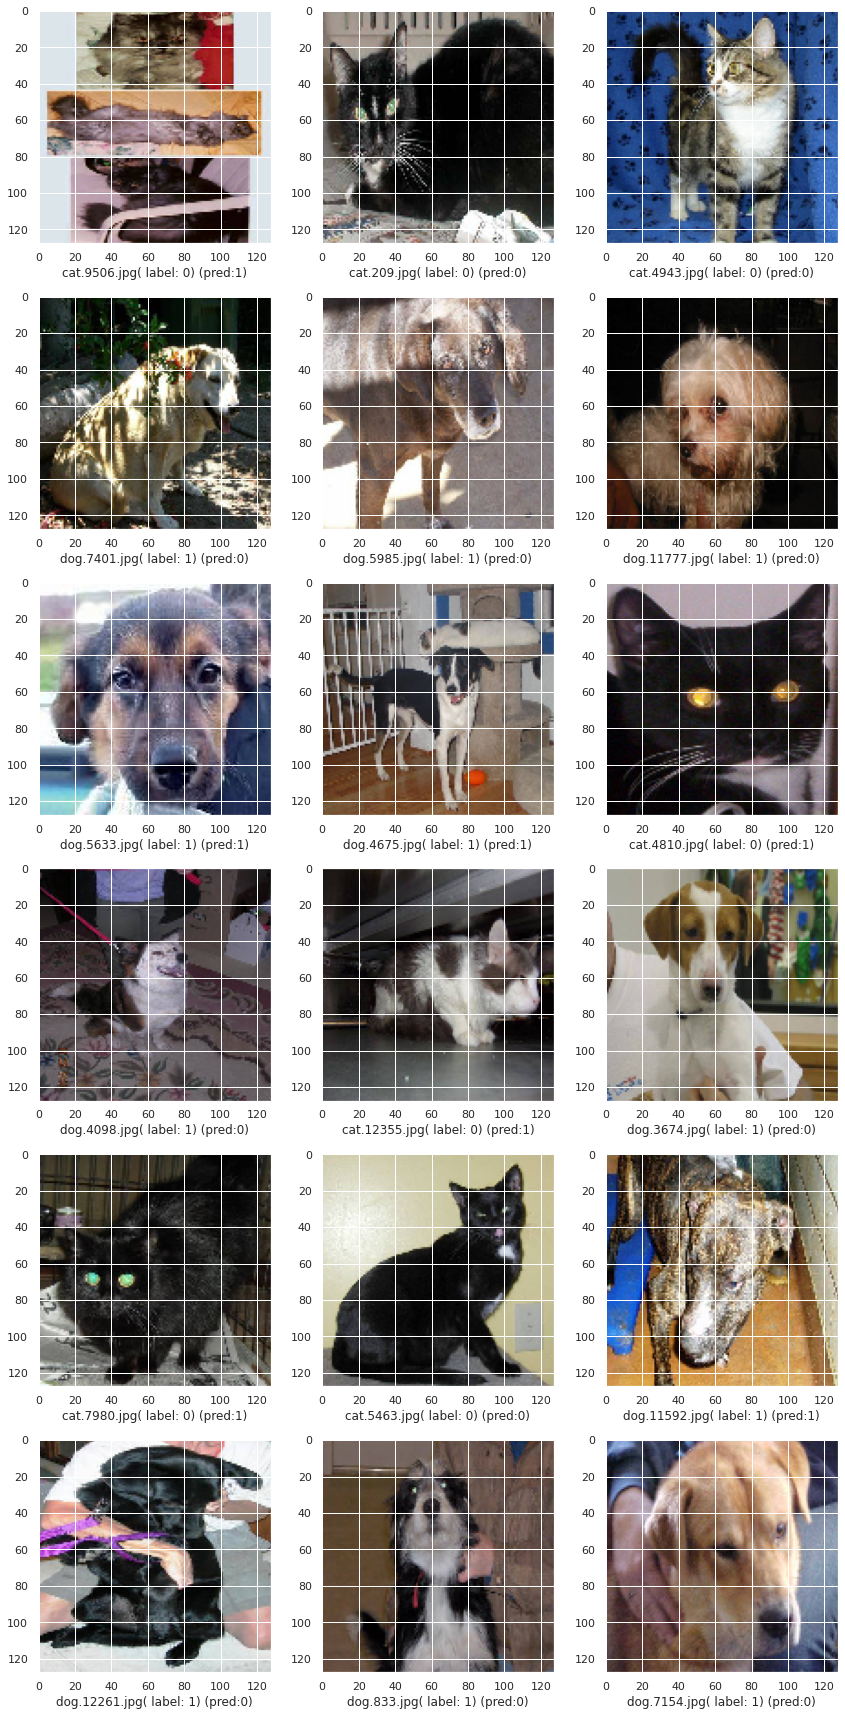

In [237]:
# usando as imagens de validação, que tem label, pra ver a predição:
sample_test = validate_df[18:36]
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    pred = row['predicted']
    img = load_img("train/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index-18+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + " label: {}".format(category) + ')' + ' ' + '(' + "pred:{}".format(pred) + ')' )
plt.tight_layout()
plt.show()

In [238]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('AI_TRABALHO_FINAL.ipynb')

--2021-12-02 20:53:37--  https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1864 (1.8K) [text/plain]
Saving to: ‘colab_pdf.py’

colab_pdf.py        100%[===================>]   1.82K  --.-KB/s    in 0s      

2021-12-02 20:53:37 (22.3 MB/s) - ‘colab_pdf.py’ saved [1864/1864]

Mounted at /content/drive/


ValueError: ignored